In [167]:
from sica.base import StabilizedICA
from sica._whitening import whitening
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys


In [180]:
input_folder = 'C:/MyPrograms/BIODICA_GUI/'
input_file = 'OVCA_ica_numerical.txt'
output_folder = 'C:/MyPrograms/BIODICA_GUI/_test/stability/'

#components = 30 #should be a single number or a list of numbers
components = [5,10,20,30]
n_runs =  100    #should be a single number >= 1

algorithm = 'fastica_par' #should be either 'fastica_par' , 'fastica_def' , 'fastica_picard' 
                 #, 'infomax' , 'infomax_ext' or 'infomax_orth'
                 
#Remark 1: - 'fastica_par' and 'fastica_def' refer to the sklearn implementation with parallel or deflation algorithm     
#          - 'infomax' , 'infomax_ext' , 'infomax_orth' refers to the infomax algorithm, its extended version and its
#            version with orthogonality constraint
#          - 'fastica_picard' refers to the extended infomax implementation with orthogonality constraint which is claimed
#            to give similar results as fastica

#Remark 2: Only 'fastica_par' has been widely tested so far

#non_linearity = 'logcosh' #should be either 'cube' , 'exp' , 'logcosh' or 'tanh'
non_linearity = 'cube' #should be either 'cube' , 'exp' , 'logcosh' or 'tanh'

#Remark : 'tanh' and 'logcosh' should refer to the same non-linearity ('logcosh' is used for
# sklearn.fastica and 'tanh' for infomax)

type_of_visualization = 'umap' # mds, umap, tsne

for i,arg in enumerate(sys.argv):
    if arg=='--components':
        components = sys.argv[i+1].split(',')
        components = [int(s) for s in components]
    if arg=='--n_runs':
        n_runs = int(sys.argv[i+1])
    if arg=='--algorithm':
        algorithm = sys.argv[i+1]
    if arg=='--non_linearity':
        non_linearity = sys.argv[i+1]
    if arg=='--type_of_visualization':
        type_of_visualization = sys.argv[i+1]
    if arg=='--input_folder':
        input_folder = sys.argv[i+1]
    if arg=='--input_file':
        input_file = sys.argv[i+1]
    if arg=='--output_folder':
        output_folder = sys.argv[i+1]

In [169]:
prefix = input_file.replace('_numerical.txt','')
print(prefix)
X = pd.read_csv(filepath_or_buffer= input_folder+input_file , header=None, index_col=None, sep = '\t').T
X = X.to_numpy()
print(X.shape)
if np.isnan(X.T[0][X.shape[0]-1]):
    X = X[0:X.shape[0]-1]
    print(X.shape)
with open(input_folder+prefix+'_ids.txt','r') as f:
    ids = f.readlines()
    ids = [s[:-1] for s in ids]
    print('Number of objects = ',len(ids))
with open(input_folder+prefix+'_samples.txt','r') as f:
    samples = f.readline().split('\t')[:-1]
    print('Number of vars = ',len(samples))
X = X.T
print(X.shape)

OVCA_ica
(414, 20806)
(413, 20806)
Number of objects =  20806
Number of vars =  413
(20806, 413)


Whitening...
Time elapsed for whitening: 0:00:00.754771 sec
(20806, 30)
Computing ICA with Python, number of components =  5
Time elapsed: 0:00:16.102642 sec


C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


Time elapsed for visualization: 0:00:02.571751 sec
Computing ICA with Python, number of components =  10
Time elapsed: 0:00:08.830143 sec


C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


Time elapsed for visualization: 0:00:02.968488 sec
Computing ICA with Python, number of components =  20
Time elapsed: 0:00:30.844359 sec


C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


Time elapsed for visualization: 0:00:03.646504 sec
Computing ICA with Python, number of components =  30
Time elapsed: 0:00:58.497519 sec


C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


Time elapsed for visualization: 0:00:06.497284 sec


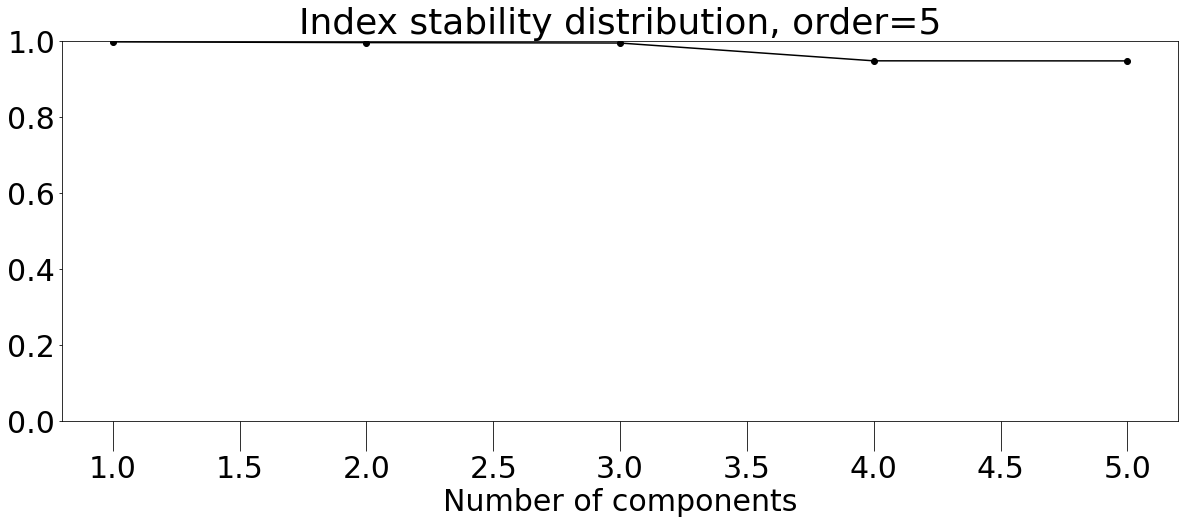

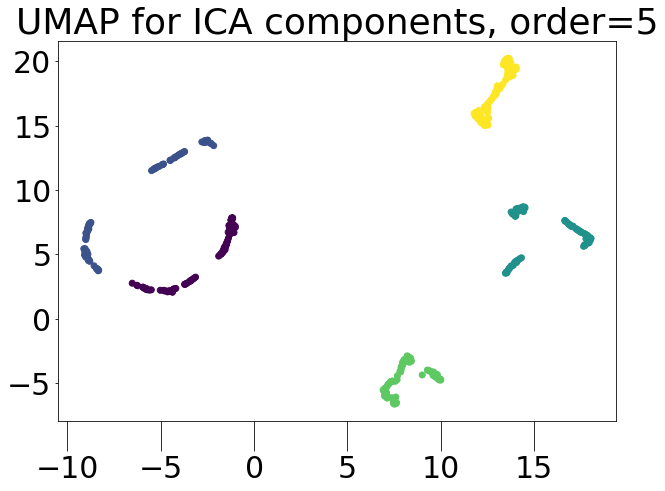

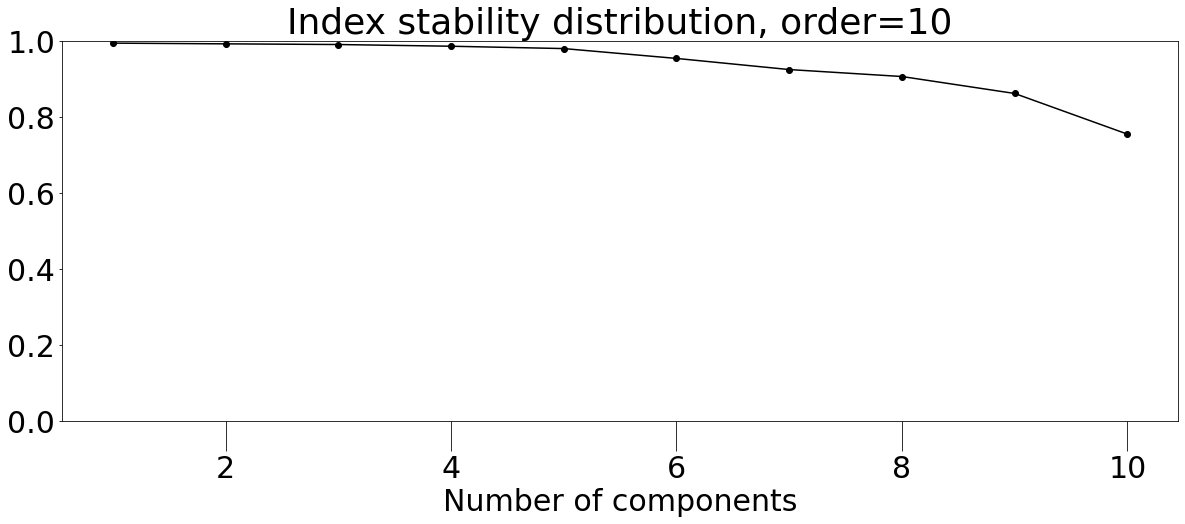

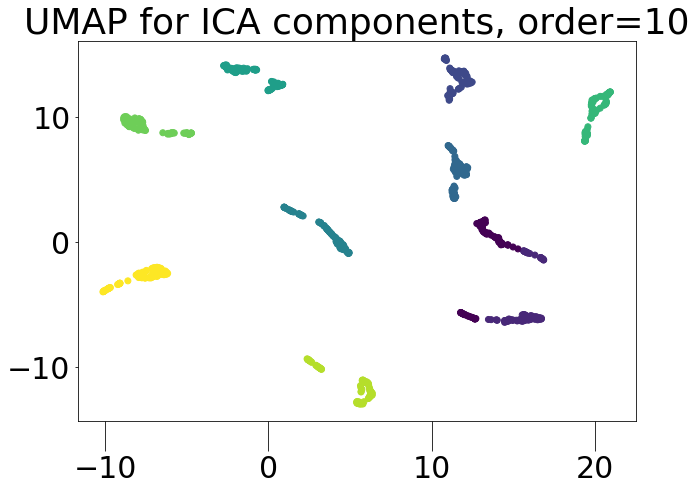

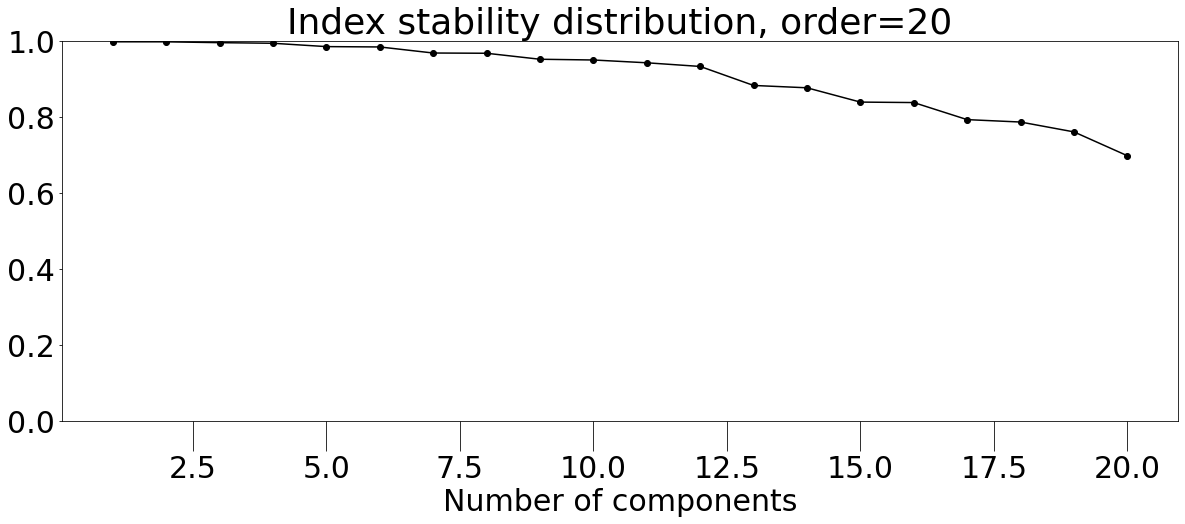

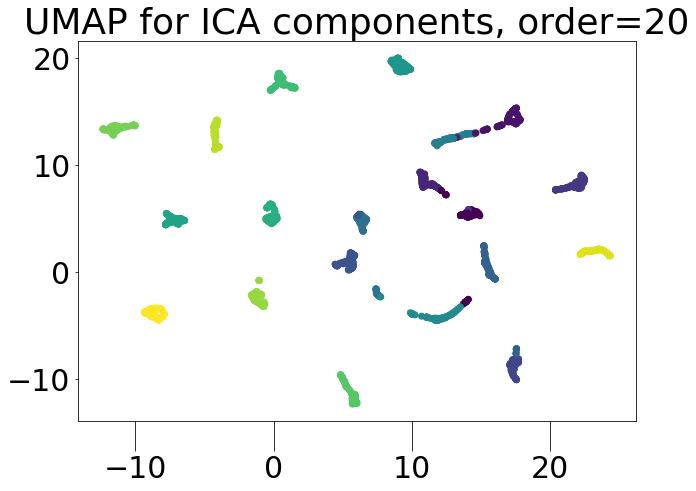

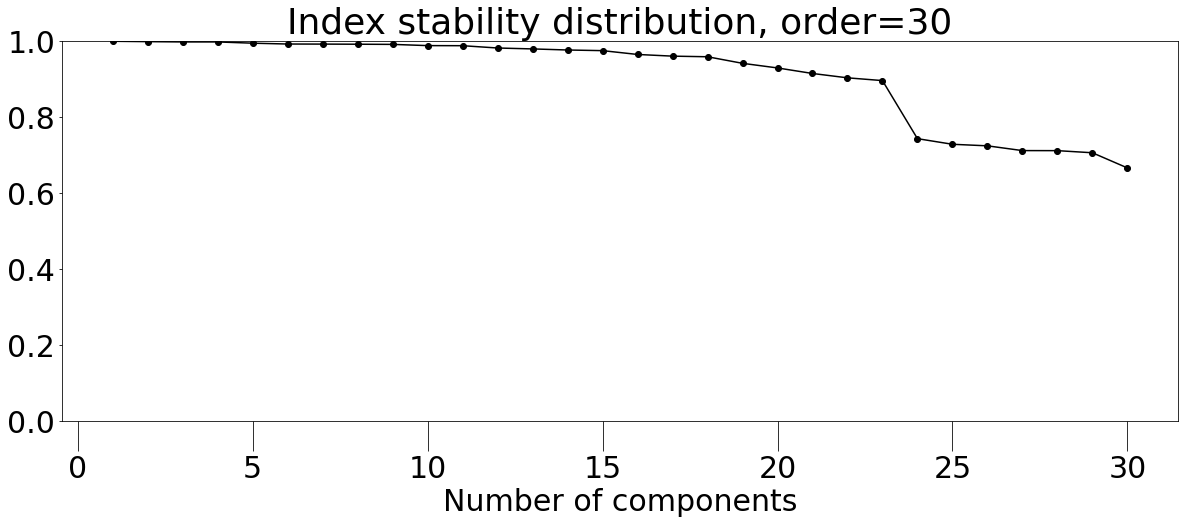

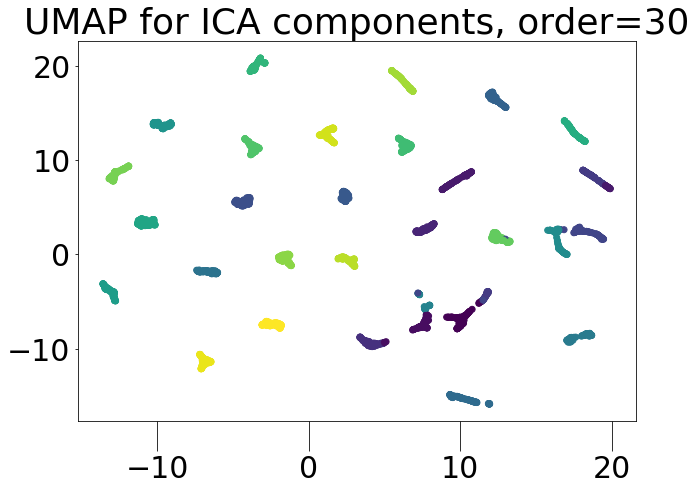

In [171]:
from timeit import default_timer as timer
from datetime import timedelta

# Create a stability directory to save the results  
os.makedirs(output_folder, exist_ok = True)   

# Read the input file and center the expression of each gene
# X = pd.read_csv(filepath_or_buffer= input_file , index_col=0).T #, sep = '\t')
#X = pd.read_csv(filepath_or_buffer= input_file , header=None, index_col=None, sep = '\t').T
#X = X.apply(func = lambda x : x - x.mean() , axis = 1)
#X = X - np.mean(X,axis=0)
#print(X)

# If components is a single number n, transform it into a list [n]
if not isinstance(components , list) :
    components = [components]

# Whiten the data with the maximum number of components to avoid repeating this
# step for each number of components
start = timer()    
print('Whitening...')
X_w = whitening(X , n_components = components[-1] , svd_solver = 'full' , chunked = False , chunk_size = None , zero_center = True)
end = timer()
print('Time elapsed for whitening:',timedelta(seconds=end-start),'sec')

print(X_w.shape)

# Create an empty figure for saving MSTD plots and an empty list for saving
# the mean stability for each number of components
mean = []

# If components is a single number n, transform it into a list [n]
if not isinstance(components , list) :
    components = list(components)

#----------Computations-------------   


mpl.rcParams['font.size']=30
mpl.rcParams['xtick.major.size']=30

# Iterate through the different numbers of components
for i in components:
    start = timer()    

    print('Computing ICA with Python, number of components = ',i)
    # Compute stabilized ica with the given non-linearity and algorithm
    sICA = StabilizedICA(i , max_iter = 2000 ,n_jobs = -1)
    sICA.fit(X_w[: , :i] , n_runs , fun = non_linearity , algorithm = algorithm , whiten = False)
    # We need to compute A ourselves since we only passed the whitened matrix to StabilizedICA
    A = (X.T).dot(np.linalg.pinv(sICA.S_))    
    end = timer()
    print('Time elapsed:',timedelta(seconds=end-start),'sec')
    
    # Save the mean stability and plot the stability distribution within the MSTD plot
    #mean.append(np.mean(sICA.stability_indexes_))
    
    fig, ax = plt.subplots(1 , 1 , figsize = (20 , 7))
    ax.plot(range(1 , len(sICA.stability_indexes_)+1) , sICA.stability_indexes_ , 'ko-')
    ax.set_title("Index stability distribution, order="+str(i))
    ax.set_xlabel("Number of components") 
    plt.ylim([0,1])
    plt.savefig(output_folder + input_file+"_"+str(i)+"_stability.png")
    
    fig , ax = plt.subplots(figsize = (10 , 7))
    start = timer()    
    sICA.projection(ax = ax , method = type_of_visualization)
    if type_of_visualization=='umap':
        ax.set_title("UMAP for ICA components, order="+str(i))
    elif type_of_visualization=='tsne':
        ax.set_title("tSNE for ICA components, order="+str(i))
    elif type_of_visualization=='mds':
        ax.set_title("MDS for ICA components, order="+str(i))
    end = timer()
    print('Time elapsed for visualization:',timedelta(seconds=end-start),'sec')
    plt.savefig(output_folder  + input_file+"_"+str(i)+".png")
    
    # Save the metagenes, the metasamples and the stability indexes
    name = ''.join(input_file.split('.')[: -1]) + '_ica_numerical.txt_' + str(i)
    np.savetxt(output_folder + 'A_' + name + '.num' , A)
    np.savetxt(output_folder + 'S_' + name + '.num' , sICA.S_.T)
    np.savetxt(output_folder + name + '_stability.txt' , np.flip(sICA.stability_indexes_).reshape((-1 ,1)))

# Finish the MSTD plot with the mean stability w.r.t the number of components and
# save it in a .png file
#ax[1].plot(components , mean , linestyle='-', marker='o')     
#ax[1].set_title("Mean stability")
#ax[1].set_xlabel("Number of components")


# Save the metagenes and the metasamples for the highest number of components in .csv format
#S = pd.DataFrame(s.S_.T , columns = ['IC' + str(i) for i in range(1 , 1 + s.S_.shape[0])])
#S = pd.DataFrame(data={'GENE':ids}).join(S)
#S.to_csv(output_folder + '\\'  + ''.join(input_file.split('.')[: -1]) + '_ica_S.xls',sep='\t',index=False)
#A = pd.DataFrame(A , columns = ['IC' + str(i) for i in range(1 , 1 + s.S_.shape[0])])
#A = pd.DataFrame(data={'SAMPLE':samples}).join(A)
#A.to_csv(output_folder + '\\' + ''.join(input_file.split('.')[: -1]) + '_ica_A.xls',sep='\t',index=False)

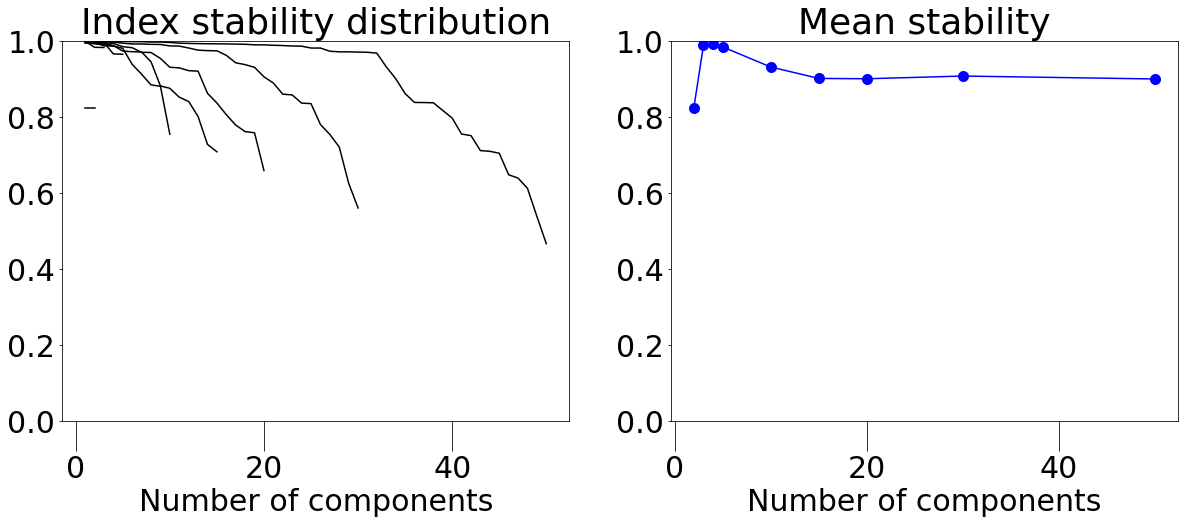

In [191]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(output_folder) if isfile(join(output_folder, f)) if 'stability.txt' in f]
fig, ax = plt.subplots(1 , 2 , figsize = (20 , 7))
mean = []
orders = []
for f in onlyfiles:
    with open(output_folder+f,'r') as fin:
        stabs = fin.readlines()
        stabs = [float(s[:-1]) for s in stabs]
        stabs.sort(reverse=True)
    orders.append(len(stabs))
    mean.append(np.mean(np.array(stabs)))
    ax[0].plot(range(1 , len(stabs)+1) , stabs , 'k')
ax[0].set_title("Index stability distribution")
ax[0].set_xlabel("Number of components")  
ax[0].set_ylim([0,1])
inds = np.argsort(orders)
ax[1].plot(np.array(orders)[inds],np.array(mean)[inds],'bo-',markersize=10)
ax[1].set_title("Mean stability")
ax[1].set_xlabel("Number of components")
ax[1].set_ylim([0,1])
plt.savefig(output_folder  + '_MSTD_estimate.png')
plt.show()